# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

### Загрузим данные

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, mean_absolute_error, make_scorer, mean_squared_error
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

import time
import calendar

In [2]:
# gold_recovery_train_new.csv — обучающая выборка;
# gold_recovery_test_new.csv — тестовая выборка;
# gold_recovery_full_new.csv — исходные данные.

df = pd.set_option('display.float_format', '{:,.2f}'.format)

train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col=['date'], parse_dates=True)
test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col=['date'], parse_dates=True)
full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col=['date'], parse_dates=True)

In [3]:
train.shape

(14149, 86)

In [4]:
test.shape

(5290, 52)

In [5]:
full.shape

(19439, 86)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

<div class="alert alert-info"> <b>Комментарий студента:</b> 

- В датасете 'test' на 34 столбца меньше.
    
- В данных есть пропуски, т.к. на момент выгрузки не все данные поступили.
    
</div>

### Проверим, что эффективность обогащения рассчитана правильно

In [9]:
# Функция рассчета эффективность обогащения по формуле
def recovery_rougher(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    Calc = row['rougher.output.recovery']
    if (F * (C-T)) == 0: R = Calc
    else: R = 100* ((C * (F-T)) / (F * (C-T)))
    return R

In [10]:
train['rougher.calculation.recovery'] = train.apply(recovery_rougher, axis=1)

In [11]:
mae = mean_absolute_error(train['rougher.output.recovery'], train['rougher.calculation.recovery']) 
f'{mae:.20f}'

'0.00000000000000973512'

In [12]:
train = train.drop('rougher.calculation.recovery', axis=1)

<div class="alert alert-info"> <b>Комментарий студента:</b> 

- Средне абсолютная ошибка стремится к 0, эффективность обогащения рассчитана правильно.
    
    
</div>

### Признаки, недоступные в тестовой выборке

In [13]:
# Найдем отсутствующие столбци
set(full.columns) - set(test.columns)   

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

<div class="alert alert-info"> <b>Комментарий студента:</b> 

В тестовой выборке отсутствуют:    
    
- выходные параметры готового продукта/сырья/отвалов на всех этапах
    
- все измеряемые параметры
      
    
</div>


### Предобработка данных

In [14]:
# Количество пропусков
print(train.isna().sum().sum())
print(test.isna().sum().sum())

4100
90


In [15]:
df_train = train.interpolate(method='time')
df_test = test.interpolate(method='time')

In [16]:
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [17]:
# Для обучение модели добавим из датасета 'full' признаки 'final.output.recovery', 'rougher.output.recovery'
df_test = df_test.join(full.loc[df_test.index][['final.output.recovery', 'rougher.output.recovery']])
df_test.shape

(5290, 54)

In [18]:
df_train.shape

(14149, 86)

<div class="alert alert-info"> <b>Комментарий студента:</b> 

Данные подготовленны, пропуски заполнены методом interpolate.
      
    
</div>


## Анализ данных

###  Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [19]:
metal_list = ['au', 'ag', 'pb']
concentrate_output = ['rougher.input.feed',
                      'rougher.output.concentrate',
                      'primary_cleaner.output.concentrate',
                      'final.output.concentrate']
concentrate_tail = ['rougher.input.feed',
                    'rougher.output.tail',
                    'primary_cleaner.output.tail',
                    'final.output.tail']

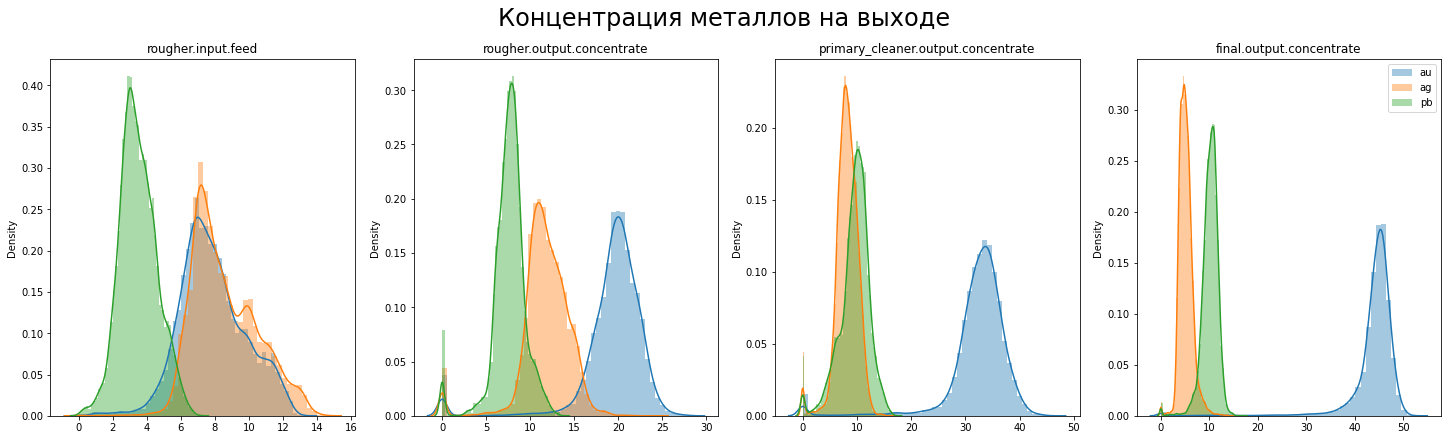

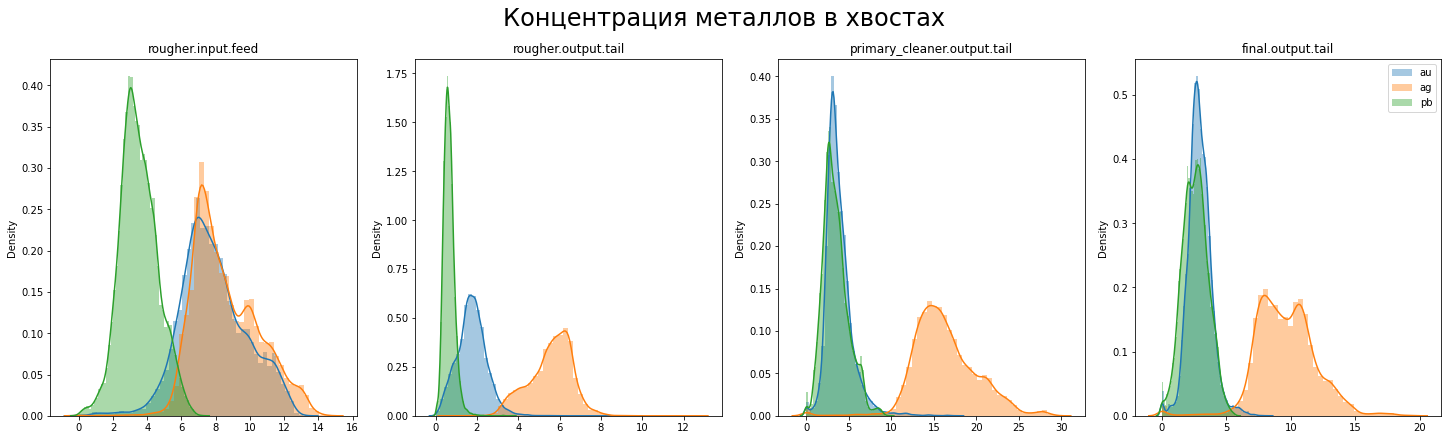

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе', fontsize=24)

for stage, ax in zip(concentrate_output, axs):
    ax.set_title(stage)
    for metal in metal_list:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвостах', fontsize=24)

for stage, ax in zip(concentrate_tail, axs):
    ax.set_title(stage)
    for metal in metal_list:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

<div class="alert alert-info"> <b>Комментарий студента:</b> 

На каждом этапе очистки концетрация золота возростает, а в хвостах падает. Так же можно отметить что довольно большое содержание серебра в хвостах.
      
    
</div>

### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.

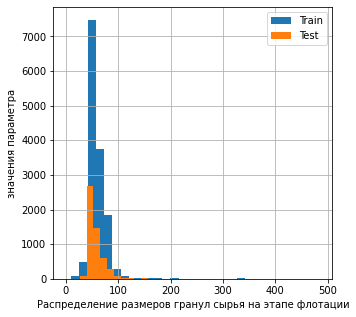

In [21]:
df_train['rougher.input.feed_size'].hist(bins=30,figsize=(5, 5))
df_test['rougher.input.feed_size'].hist(bins=30)

plt.legend(['Train','Test'])
plt.xlabel('Распределение размеров гранул сырья на этапе флотации')
plt.ylabel('значения параметра')
plt.show()

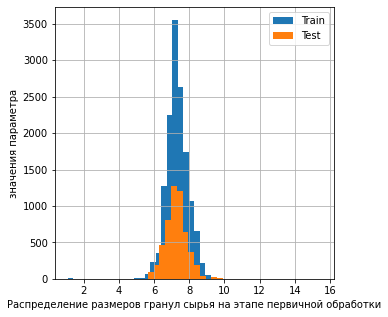

In [22]:
df_train['primary_cleaner.input.feed_size'].hist(bins=30,figsize=(5, 5))
df_test['primary_cleaner.input.feed_size'].hist(bins=30)

plt.legend(['Train','Test'])
plt.xlabel('Распределение размеров гранул сырья на этапе первичной обработки')
plt.ylabel('значения параметра')
plt.show()

<div class="alert alert-info"> <b>Комментарий студента:</b> 

Исходя из распределения размера гранул на этапе флотации и первичной обработки, не считая выбросов, распределение в одном диапозоне.
      
    
</div>

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [23]:
# Удалим 0 значения
list_metal = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
             'final.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
             'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_au',
             'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
for x in list_metal:
    df_train = df_train.drop(df_train[df_train[x] == 0].index)
    df_train = df_train.drop(df_train[df_train[x] == 0].index)
    df_train = df_train.drop(df_train[df_train[x] == 0].index)

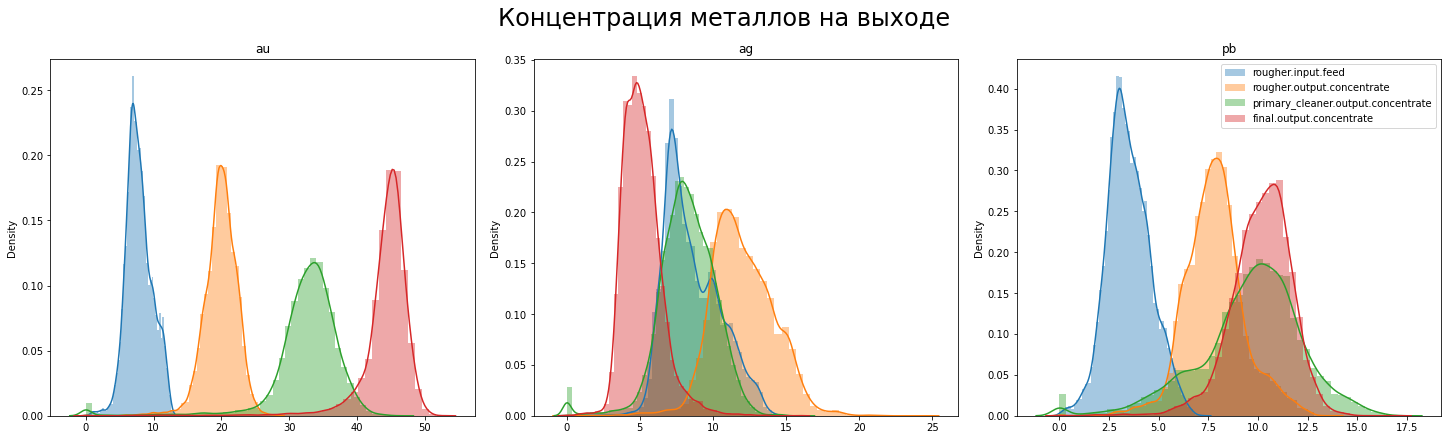

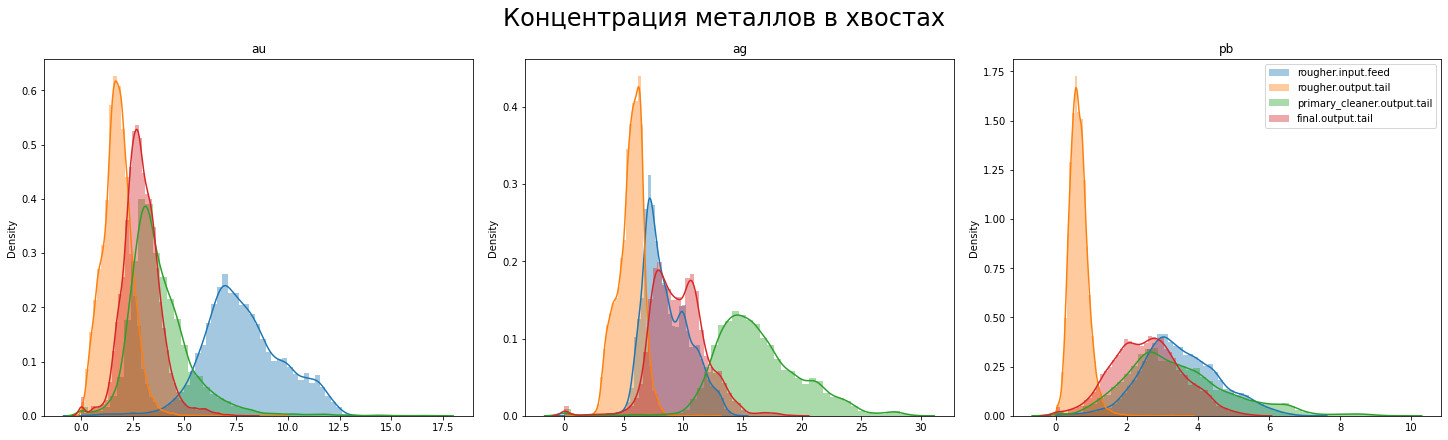

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе', fontsize=24)

for metal, ax in zip(metal_list, axs):
    ax.set_title(metal)
    for stage in concentrate_output:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=stage, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвостах', fontsize=24)

for metal, ax in zip(metal_list, axs):
    ax.set_title(metal)
    for stage in concentrate_tail:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

<div class="alert alert-info"> <b>Комментарий студента:</b> 

После каждого этапа очистки концетрация золота увеличивается, а остатки в хвостах минимальны.Распределение остальных металлов не равномерное и в минимальных значениях.
      
    
</div>

<div class="alert alert-info"> <b>Комментарий студента V2:</b> 

Удалил 0 выбросы на этапах очистки.
      
    
</div>

## Модель

### Функция для вычисления итоговой sMAPE.

In [21]:
def smape(target, predictions):
    return ((1/len(target)) * np.sum(2 * np.abs(target - predictions) / (np.abs(target) + np.abs(predictions)))) * 100

In [22]:
def total_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final

### Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [23]:
df_train = df_train[df_test.columns]

In [24]:
print(df_train.shape)
print(df_test.shape)

(14149, 54)
(5290, 54)


In [25]:
features_train_rougher = df_train
features_test_rougher = df_test
target_train_rougher = full.loc[features_train_rougher.index, 'rougher.output.recovery']
target_test_rougher = full.loc[features_test_rougher.index, 'final.output.recovery']

features_train_final = df_train
features_test_final = df_test
target_train_final = full.loc[features_train_final.index, 'final.output.recovery']
target_test_final = full.loc[features_test_final.index, 'final.output.recovery']

In [26]:
print(features_train_rougher.shape, features_train_final.shape)
print(features_test_rougher.shape, features_test_final.shape)
print(target_train_rougher.shape, target_train_final.shape)
print(target_test_rougher.shape, target_test_final.shape)

(14149, 54) (14149, 54)
(5290, 54) (5290, 54)
(14149,) (14149,)
(5290,) (5290,)


In [27]:
target_test_final

date
2016-09-01 00:59:59   70.27
2016-09-01 01:59:59   68.91
2016-09-01 02:59:59   68.14
2016-09-01 03:59:59   67.78
2016-09-01 04:59:59   61.47
                       ... 
2017-12-31 19:59:59   68.92
2017-12-31 20:59:59   68.44
2017-12-31 21:59:59   67.09
2017-12-31 22:59:59   68.06
2017-12-31 23:59:59   71.70
Name: final.output.recovery, Length: 5290, dtype: float64

In [32]:
# Выберем три модели и параметры 
from sklearn.impute import SimpleImputer
from numpy.random import RandomState
state = RandomState(12345)

pipe = Pipeline([('imp', SimpleImputer(missing_values=np.nan)),
                 ('scaler', StandardScaler()),
                 ('model', RandomForestRegressor(n_estimators=100, random_state=state))])

params = [
    {
        'imp__strategy': ['mean', 'median'],
        'model': [RandomForestRegressor(n_estimators=10, random_state=state)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'imp__strategy': ['mean', 'median'],
        'model': [LinearRegression()]
    }, {
        'imp__strategy': ['mean', 'median'],
        'model': [linear_model.Lasso(random_state=state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]

In [33]:
smape_score = make_scorer(smape, greate_is_better=False)

In [34]:
# Проверим кросс валидацию
cross_valid = KFold(n_splits=5, shuffle=False)
model_rougher = GridSearchCV(pipe, param_grid=params, cv=cross_valid, n_jobs=-1, scoring=smape_score)

In [35]:
model_rougher.fit(features_train_rougher, target_train_rougher)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=RandomState(MT19937) at 0x7FF9FCE81540))]),
             n_jobs=-1,
             param_grid=[{'imp__strategy': ['mean', 'median'],
                          'model': [RandomForestRegressor(max_features=0.1,
                                                          n_estimators=10,...
                          'model': [LinearRegression()]},
                         {'imp__strategy': ['mean', 'median'],
                          'model': [Lasso(random_state=RandomState(MT19937) at 0x7FF9FCE81540)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.

In [36]:
print(f'Лучшие параметры для модели:{model_rougher.best_params_}')

Лучшие параметры для модели:{'imp__strategy': 'mean', 'model': RandomForestRegressor(max_features=0.1, n_estimators=10,
                      random_state=RandomState(MT19937) at 0x7FF9FCE81540), 'model__max_features': 0.1}


In [37]:
model_final = GridSearchCV(pipe, param_grid=params, cv=cross_valid, n_jobs=-1,scoring=smape_score)

In [38]:
model_final.fit(features_train_final, target_train_final)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=RandomState(MT19937) at 0x7FF9FCE81540))]),
             n_jobs=-1,
             param_grid=[{'imp__strategy': ['mean', 'median'],
                          'model': [RandomForestRegressor(max_features=0.1,
                                                          n_estimators=10,...
                          'model': [LinearRegression()]},
                         {'imp__strategy': ['mean', 'median'],
                          'model': [Lasso(random_state=RandomState(MT19937) at 0x7FF9FCE81540)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.

In [39]:
print(f'Лучшие параметры для модели:{model_final.best_params_}')

Лучшие параметры для модели:{'imp__strategy': 'mean', 'model': RandomForestRegressor(max_features=0.1, n_estimators=10,
                      random_state=RandomState(MT19937) at 0x7FF9FCE81540), 'model__max_features': 0.1}


In [40]:
#Модель с лучшими параметрами для Тестовой выборки Rougher
rougher = model_rougher.best_estimator_

rougher.fit(features_train_rougher, target_train_rougher)
predictions = rougher.predict(features_test_rougher)

smape_rougher = smape(full.loc[target_test_rougher.index, 'rougher.output.recovery'], predictions)
smape_rougher

6.297867470507086

In [41]:
#Модель с лучшими параметрами для Тестовой выборки Final
final = model_final.best_estimator_
    
final.fit(features_train_final, target_train_final)
predictions_final = final.predict(features_test_final)

smape_final = smape(full.loc[target_test_final.index, 'final.output.recovery'], predictions_final)
smape_final

5.687236968505832

In [42]:
#Итоговый smape 
total_smape(smape_rougher, smape_final)

5.839894594006146

In [43]:
from sklearn.dummy import DummyRegressor
dummy_regressor_rougher = DummyRegressor(strategy="median")
dummy_regressor_rougher.fit(features_train_rougher, target_train_rougher)
dummy_rougher_pred = dummy_regressor_rougher.predict(features_test_rougher)
smape_dummy_rougher = smape(full.loc[target_test_rougher.index, 'rougher.output.recovery'], dummy_rougher_pred)
print(smape_dummy_rougher)


8.524314629416791


In [31]:
from sklearn.dummy import DummyRegressor
dummy_regressor_final = DummyRegressor(strategy="median")
dummy_regressor_final.fit(features_train_final, target_train_final)
dummy_final_pred = dummy_regressor_final.predict(features_test_final)
smape_dummy_final = smape(full.loc[target_test_final.index, 'final.output.recovery'], dummy_final_pred)
print(smape_dummy_final)

6.763982508185251


<div class="alert alert-info"> <b>Комментарий студента:</b> 

Вывод:
    
- Исходя из анализа данных, концентрация золота растет на каждом этапе очистки, а в хвостах уменьшается. 

- С помощью GridSearchCV из 3 моделей нашли лучшую RandomForestRegressor. На этапе флотации показатель sMAPE 7.48, на финальном этапе sMAPE 5.74.

- Итоговое sMAPE  6.18, попадает в  диапазон 7-10%.
      
    
</div>

<div class="alert alert-info"> <b>Комментарий студента V2:</b> 

Вывод:
    
После удаления 0 значений прогрноз модели улучшился. 
    
Dummy модель предсказывает хуже 8,5% против 5,8%
      
П.С.
    Спасибо за ревью и комметарии. Надеюсь еще увидимся.
</div>